In [2]:
import ppuu.lightning_modules.policy
import imp
imp.reload(ppuu.lightning_modules)
Module = ppuu.lightning_modules.policy.MPURDreamingV2Module

from ppuu.train_policy import main

!export WANDB_MODE=dryrun

import random

config = Module.Config()
config.model_config.model_type = 'dreaming_v2'
config.training_config.set_dataset('50')
config.training_config.epoch_size = 10
config.training_config.n_epochs = 0
config.training_config.seed = random.randint(0, 1000)
config.training_config.batch_size = 1
config.training_config.validation_size = 10
config.training_config.n_z_updates = 20
config.training_config.lrt_z = 0.1
config.training_config.output_dir = '/home/us441/vlad/garbage'
config.cost_config.uncertainty_n_batches = 10 
config.cost_config.u_reg = 0.05
config.cost_config.dreaming_z_reg = 0.1
model = main(config)

In [6]:
model.config.training_config

MPURDreamingV2Module.TrainingConfig(learning_rate=0.0001, n_epochs=0, n_steps=0, epoch_size=10, batch_size=1, validation_size=10, validation_period=1, dataset='/home/us441/nvidia-collab/vlad/traffic-data-5-small/state-action-cost/data_i80_v0/', data_shift=False, random_actions=False, seed=226, output_dir='/home/us441/vlad/garbage', experiment_name='train_mpur', slurm=False, slurm_constraint='turing', run_eval=False, debug=False, fast_dev_run=False, freeze_encoder=False, mixout_p=None, validation_eval=True, noise_augmentation_std=0.07, noise_augmentation_p=0.5, gpus=1, num_nodes=1, distributed_backend='ddp', resume_from_checkpoint=None, version=None, lrt_z=0.1, n_z_updates=20, adversarial_frequency=10, n_adversarial_policy_updates=1, init_z_with_zero=False)

In [7]:
import torch
import numpy as np
from matplotlib import pyplot as plt

def plot_images(images):
    images = images.detach().cpu().numpy()
    f, axs = plt.subplots(1, 10, dpi=200)
    for i in range(10):
        image = np.transpose(images[0][i * 3], (1, 2, 0))
        axs[i].imshow(image)
        axs[i].set_axis_off()

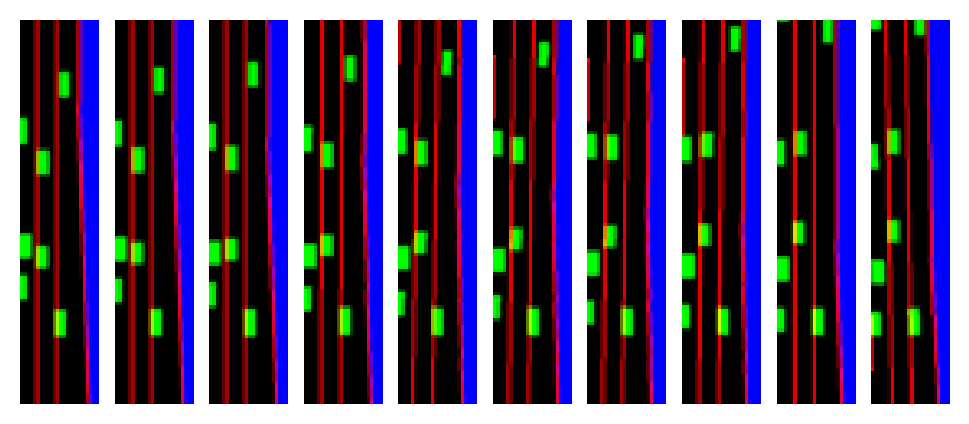

In [8]:
train_dataloader = model.train_dataloader()
batch = next(iter(train_dataloader))
batch = next(iter(train_dataloader))
batch = next(iter(train_dataloader))
plot_images(batch['target_images'])
for k in batch:
    if torch.is_tensor(batch[k]):
        batch[k] = batch[k].cuda()

In [9]:
import time
model.cuda()
res = model.forward(batch)
t = time.time()
res_adv = model.forward_adversarial(batch)
print(time.time() - t)
t = time.time()


8.9103364944458


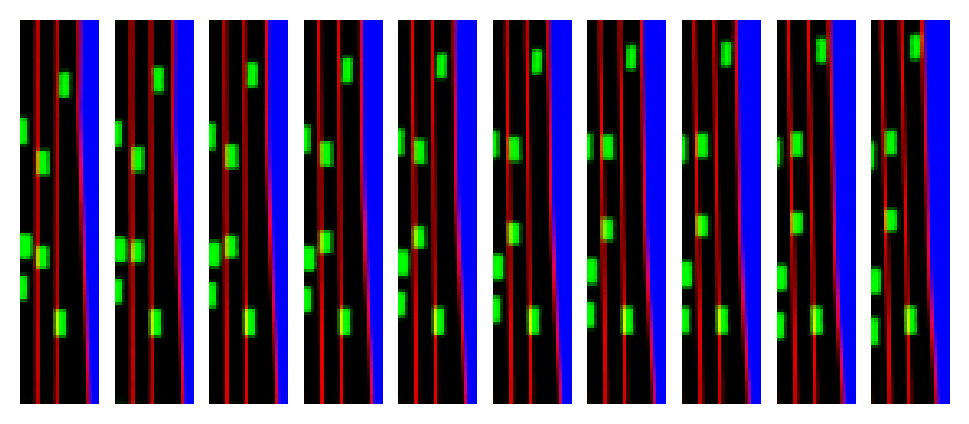

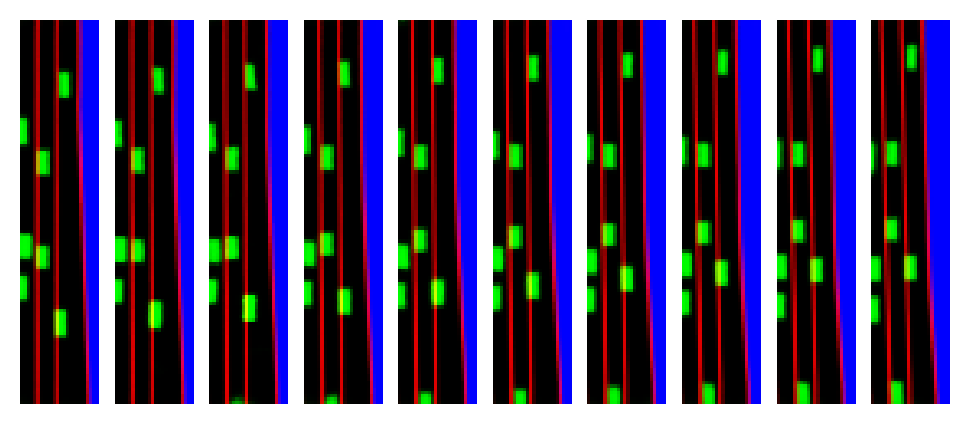

In [10]:
plot_images(res['pred_images'])
plot_images(res_adv['pred_images'])

In [11]:
res_adv.keys()

dict_keys(['pred_images', 'pred_states', 'pred_actions', 'Z'])

In [12]:
len(model.logger.custom_logs['z_cost_uncertainty'])

20

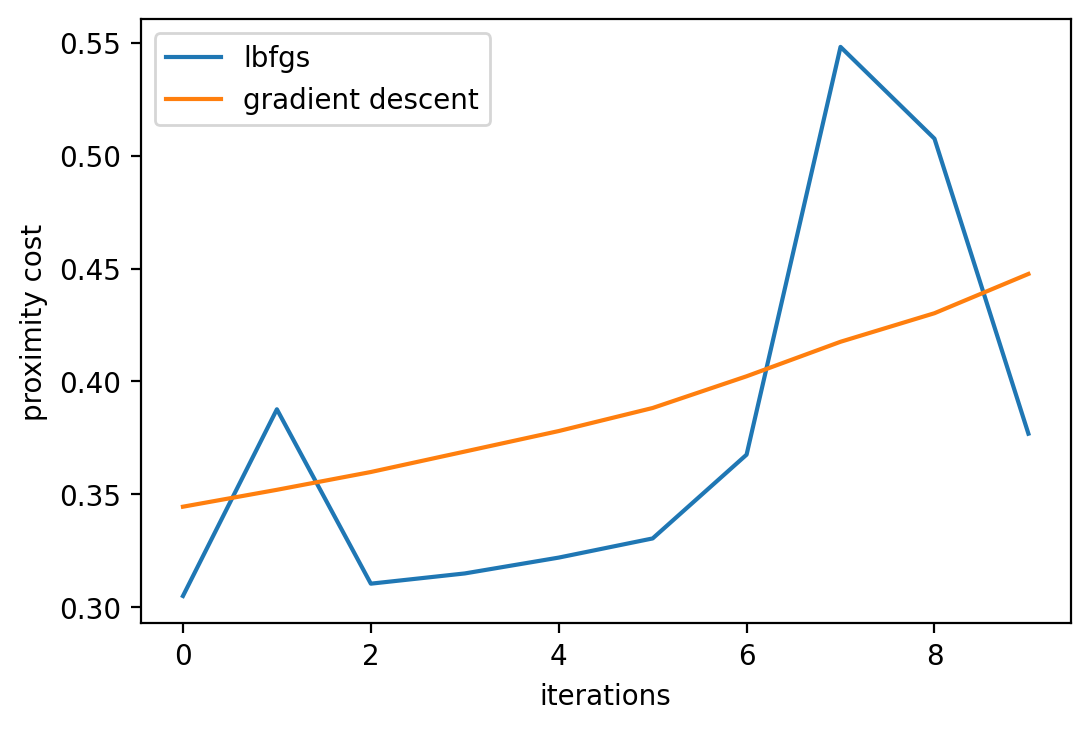

In [16]:
values = list(map(lambda x : x[0], model.logger.custom_logs['z_cost_proximity'][-50:]))
values2 = list(map(lambda x : x[0], model2.logger.custom_logs['z_cost_proximity'][-50:]))

plt.figure(dpi=200)
plt.plot(values[-10:], label='lbfgs')
plt.plot(values2[-10:], label='gradient descent')
plt.xlabel('iterations')
plt.ylabel('proximity cost')
plt.legend()

In [8]:
res['Z'].sum()

tensor(51.0238, device='cuda:0')